In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [35]:
boston_calendar = pd.read_csv('boston-airbnb-open-data/calendar.csv')

In [36]:
boston_calendar.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

First we remove the duplicate rows found in Understanding.ipynb

In [37]:
boston_calendar_different = boston_calendar[boston_calendar.listing_id == 12898806]
indices = boston_calendar_different.sort_values(by = 'date')[::2].index
boston_calendar.drop(index = indices, inplace=True)
print(f'Calendar shape is {boston_calendar.shape}')
print(f'{3585}x{365} = {3585*365}')

Calendar shape is (1308525, 4)
3585x365 = 1308525


First we get the indices of the first day of each month to be used for plotting later. 

In [38]:
boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [47]:
one_listing = boston_calendar[boston_calendar.listing_id == 12147973]
one_listing = one_listing.sort_values(by = 'date')
one_listing = one_listing.reset_index()
first_day_each_month = []
months = [f'0{i}' if i <10 else f'{i}' for i in range(1,12+1)]
for mon in months:
    for ind,date in zip(one_listing.date.index,one_listing.date):
        if date[-5:] == f'{mon}-01':
            first_day_each_month.append(ind)

In [48]:
print(first_day_each_month,len(first_day_each_month))

[117, 148, 176, 207, 237, 268, 298, 329, 360, 25, 56, 86] 12


Looks like we are right.

Right now, it feels right to change t/f to True/False

In [49]:
boston_calendar.available =boston_calendar.available.map({'t':True,'f':False})

Next, we take a look at each listing individually and count the number of days where there are prices available

In [50]:
num_days = boston_calendar[['listing_id','available']].groupby(by=['listing_id']).sum(columns = 'available')
num_days

,available
listing_id,
3353,249
5506,344
6695,324
6976,319
8792,248
9273,364
9765,362
9824,323
9855,364


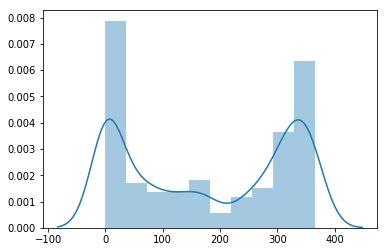

In [51]:
sns.distplot(num_days.available.tolist(), kde=True);

In [52]:
num_days.shape

(3585, 1)

We first analyze the data where the prices are available for the whole calendar year then will analyze the other data

In [53]:
num_days[num_days.available==365]

,available
listing_id,
10811,365
45987,365
59776,365
182049,365
238846,365
973695,365
994317,365
1094599,365
1106555,365


In [54]:
complete_id_list = num_days[num_days.available==365].index.tolist()

Next we pick the values that are not constant all year long

In [55]:
price_not_same = []
for id_ in  range(len(complete_id_list)):
    listing = boston_calendar[boston_calendar.listing_id == complete_id_list[id_]]
    listing['price'] = listing['price'].map(lambda x: float(''.join(e for e in x if e.isalnum()))/100) ## from $## to ## 
    if listing.price.mean() != listing.iloc[0,3]:
        price_not_same.append(id_)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [56]:
len(price_not_same)

58

let's take a look at 20 random entries from those

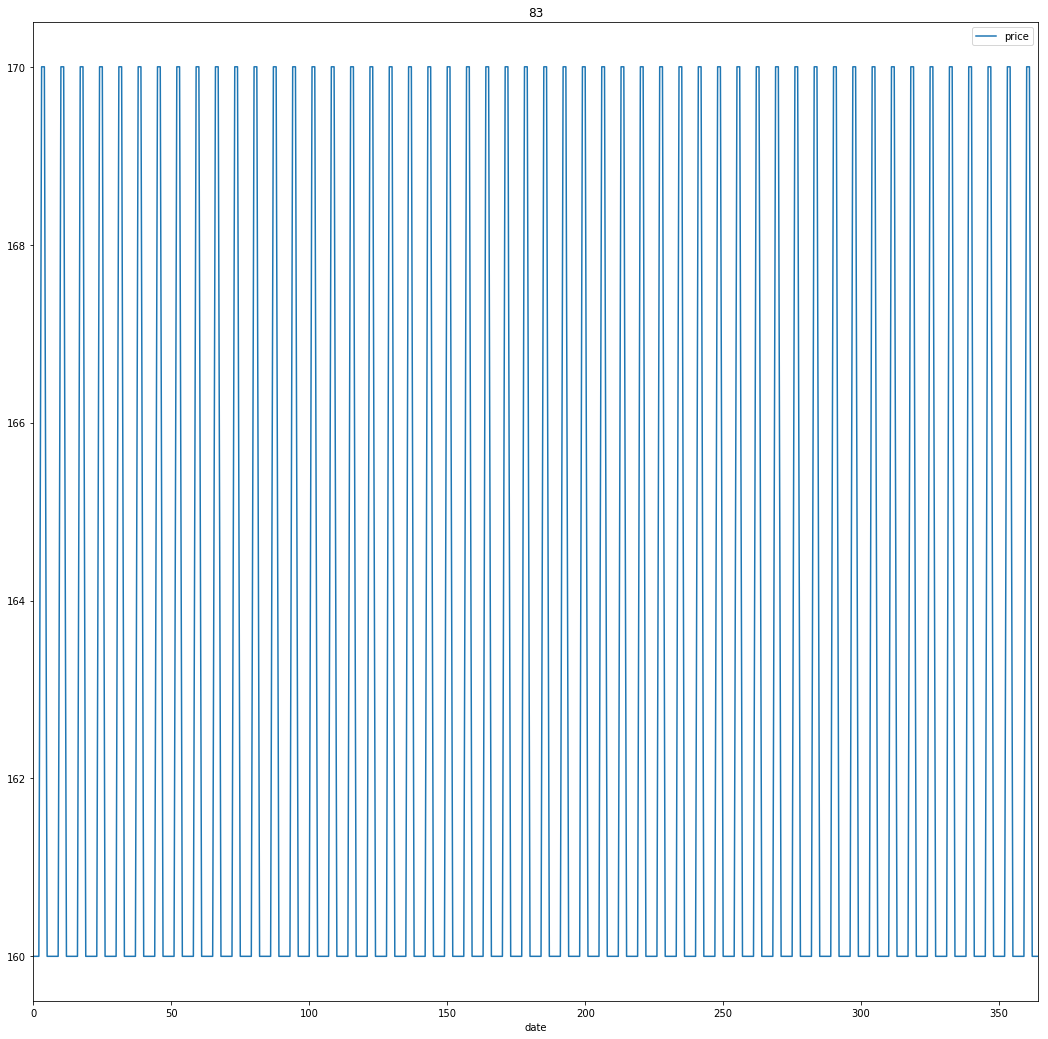

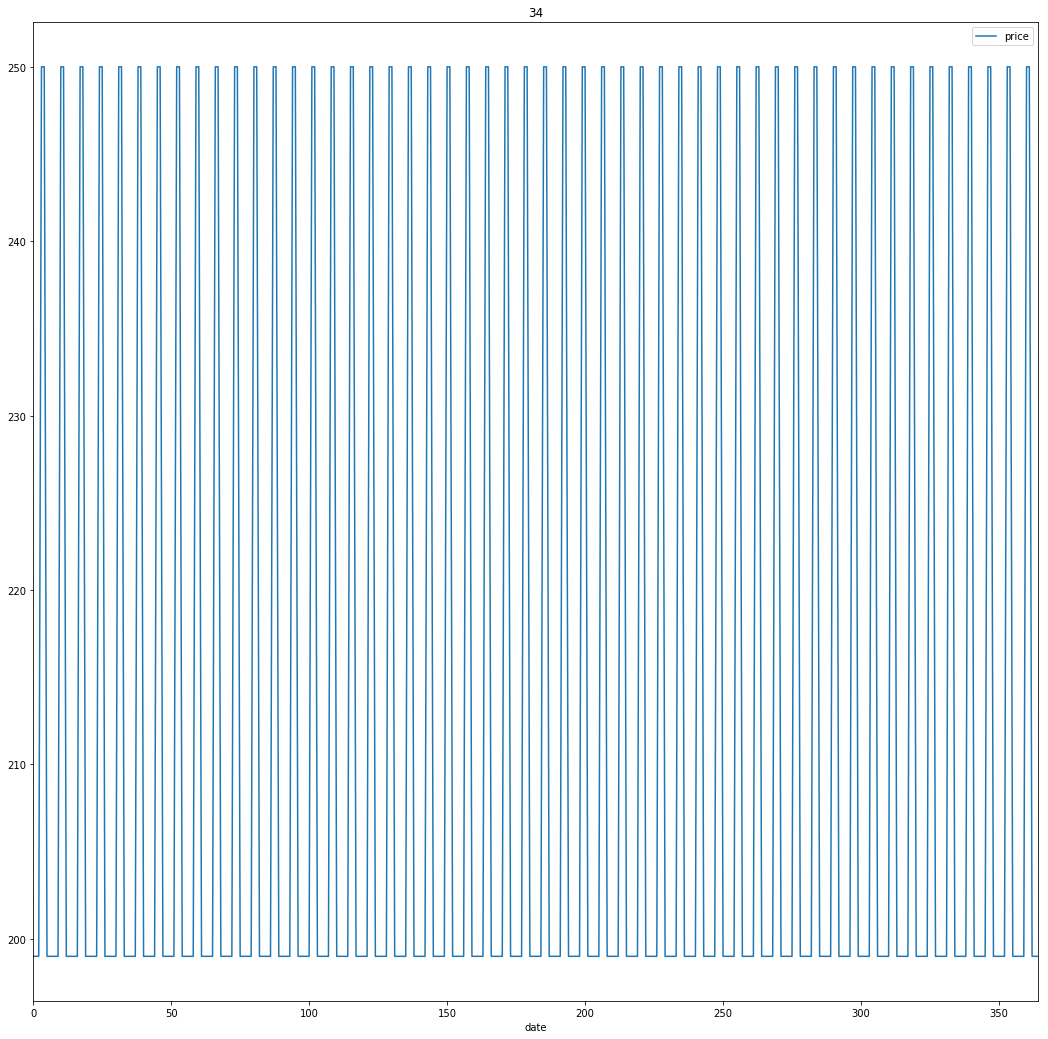

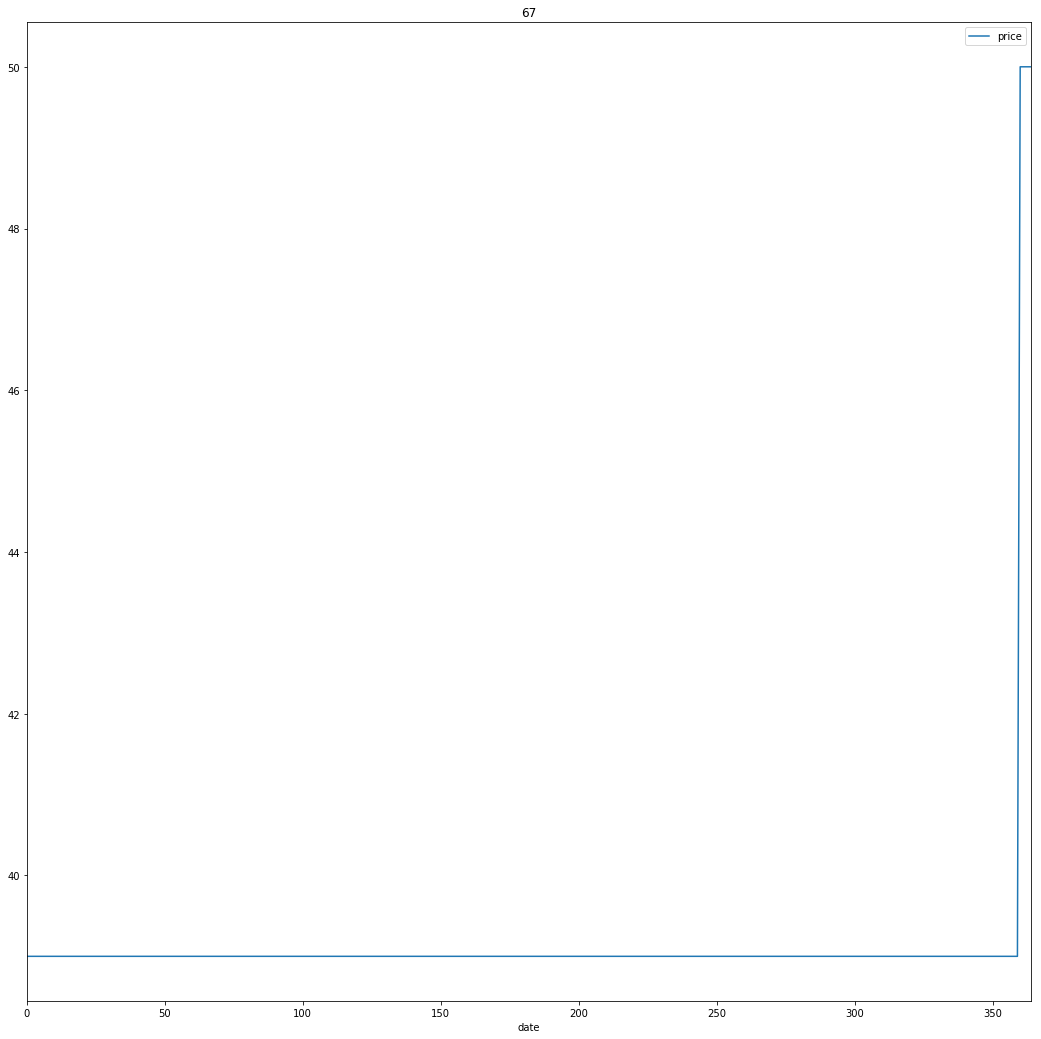

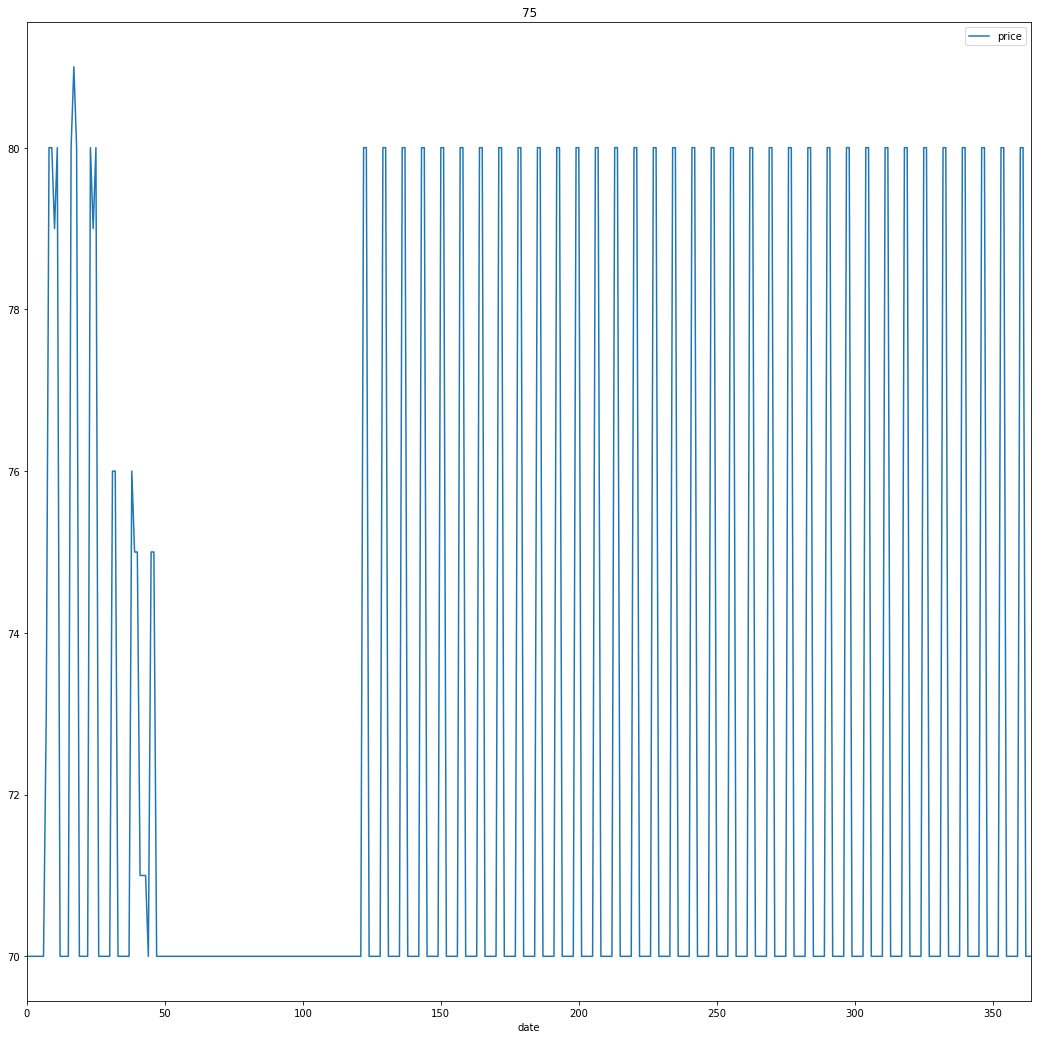

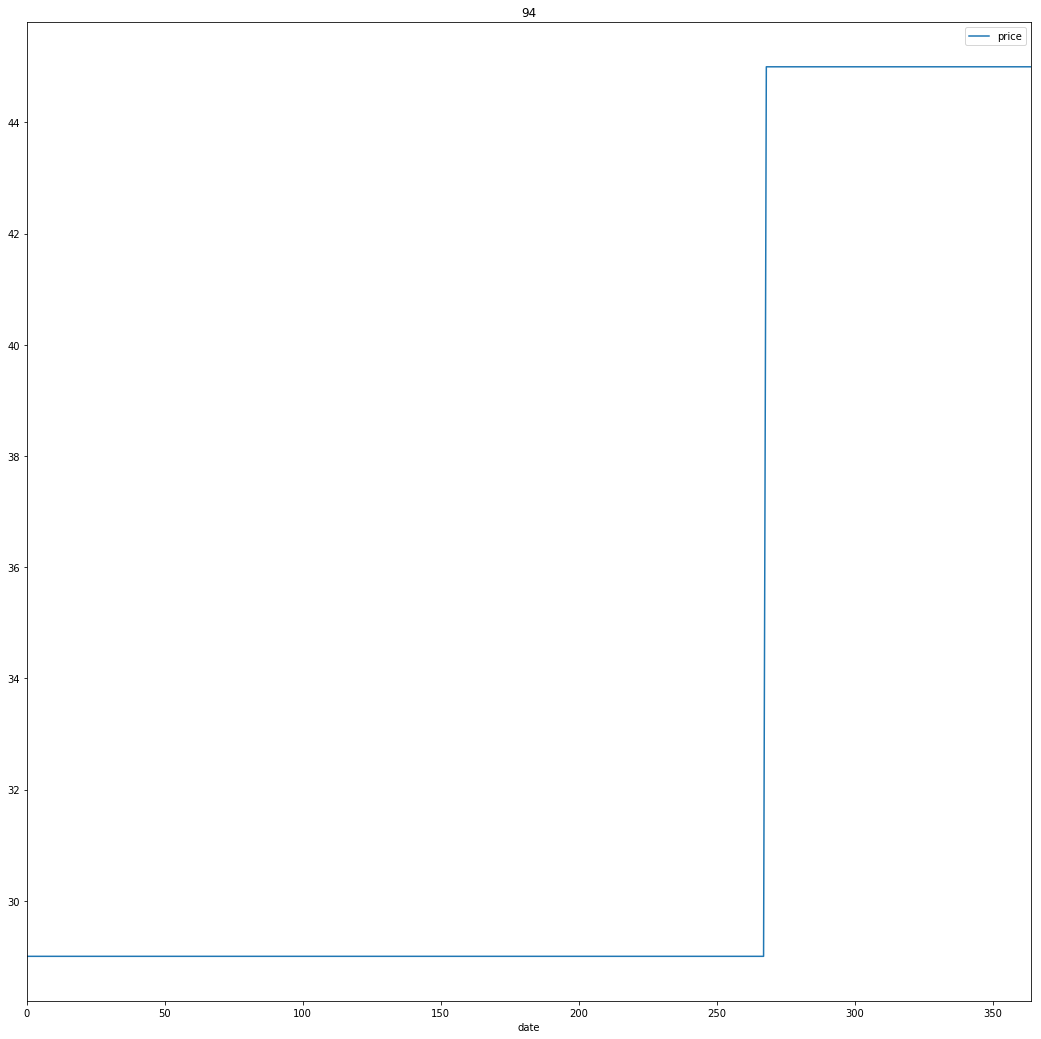

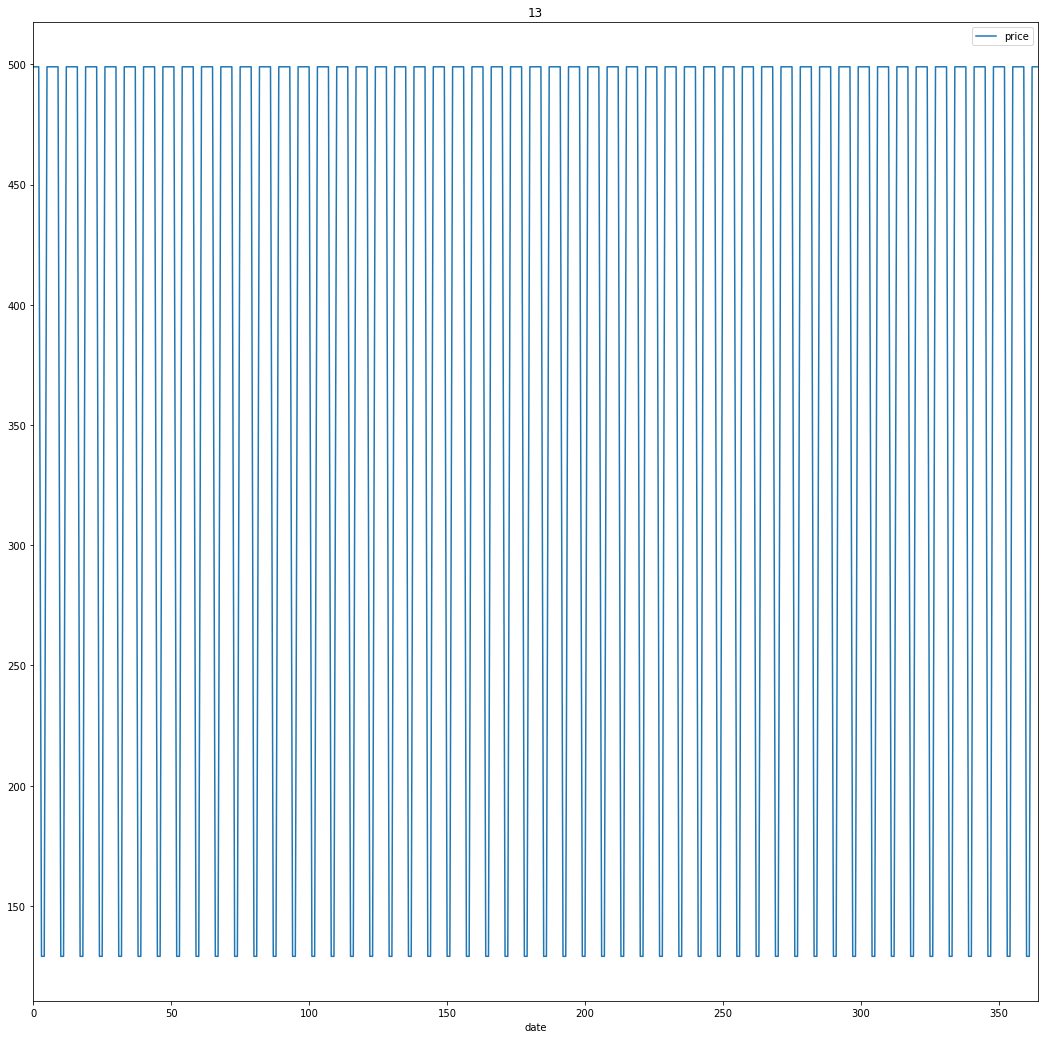

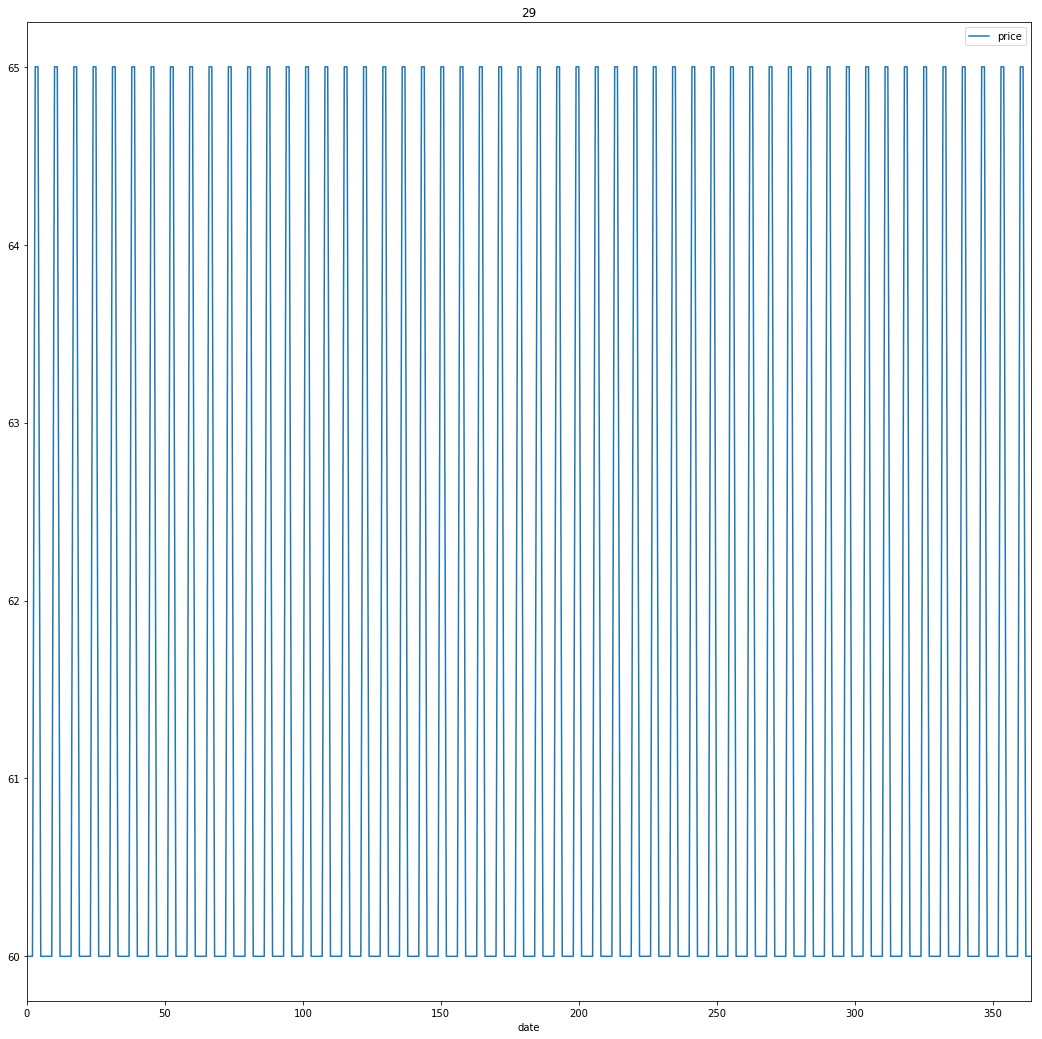

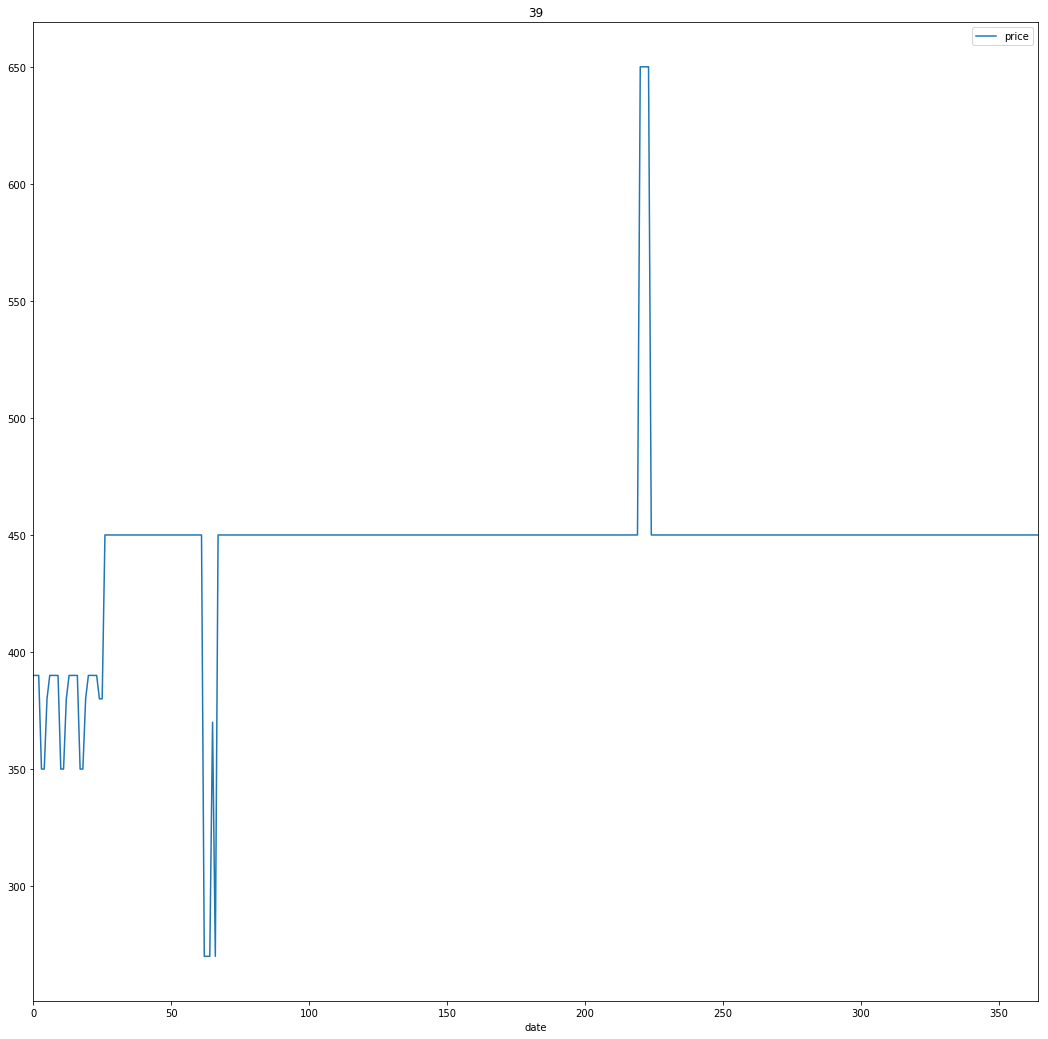

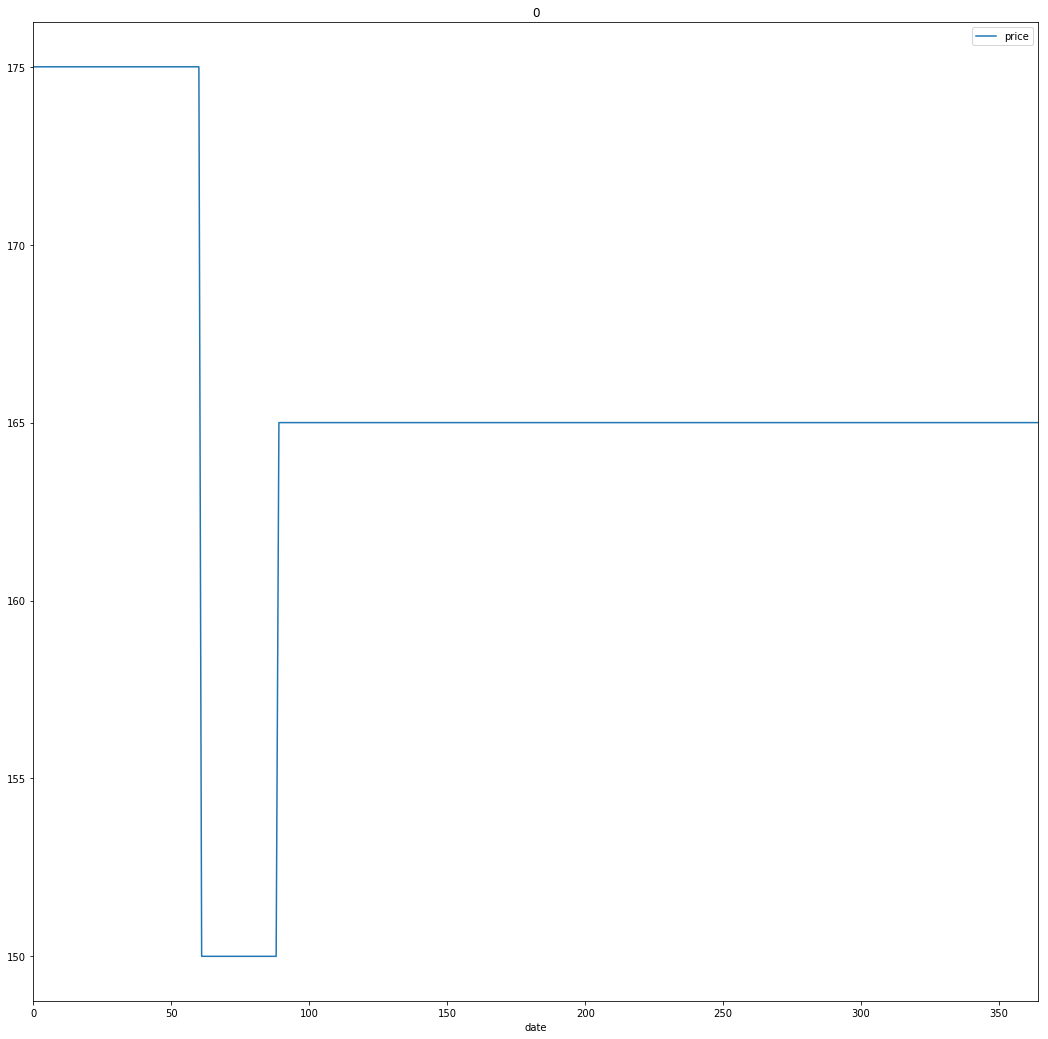

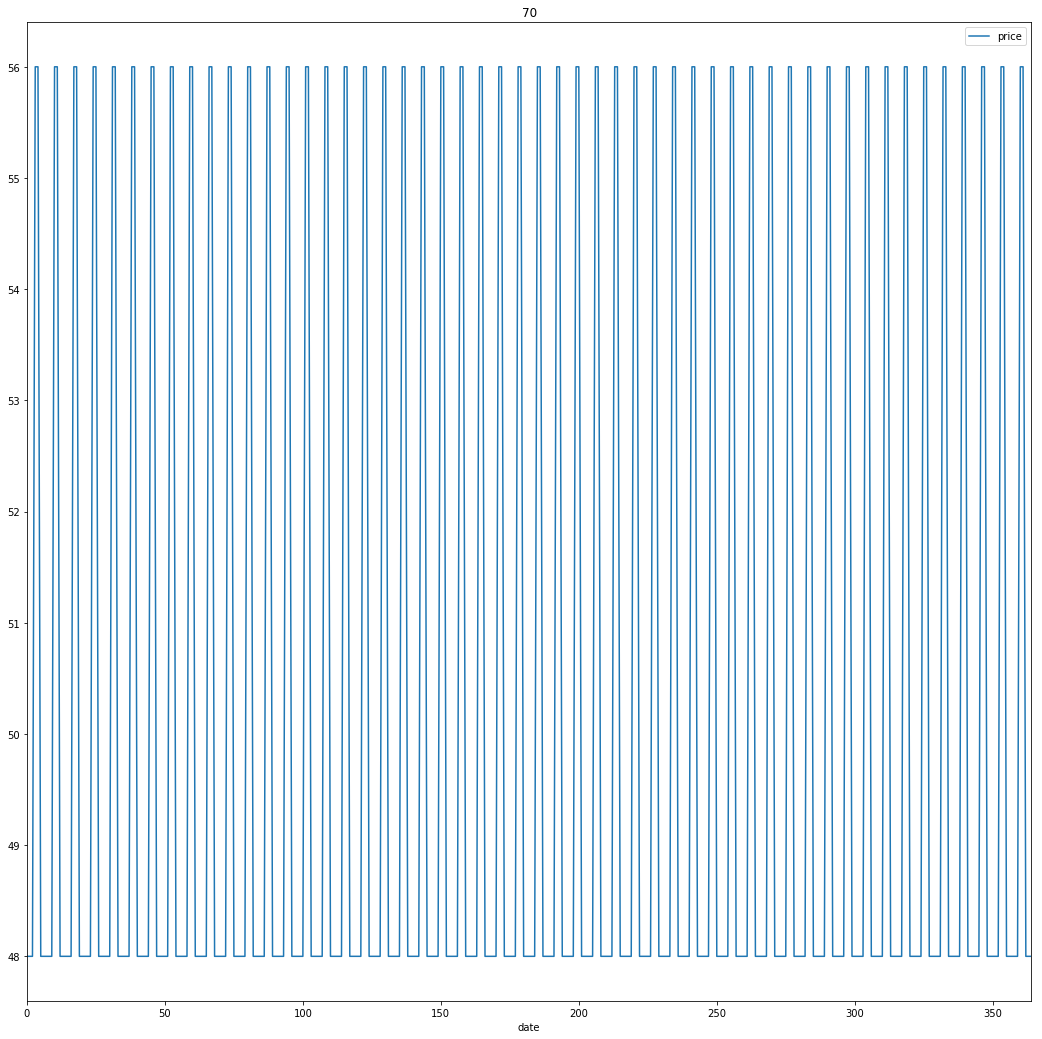

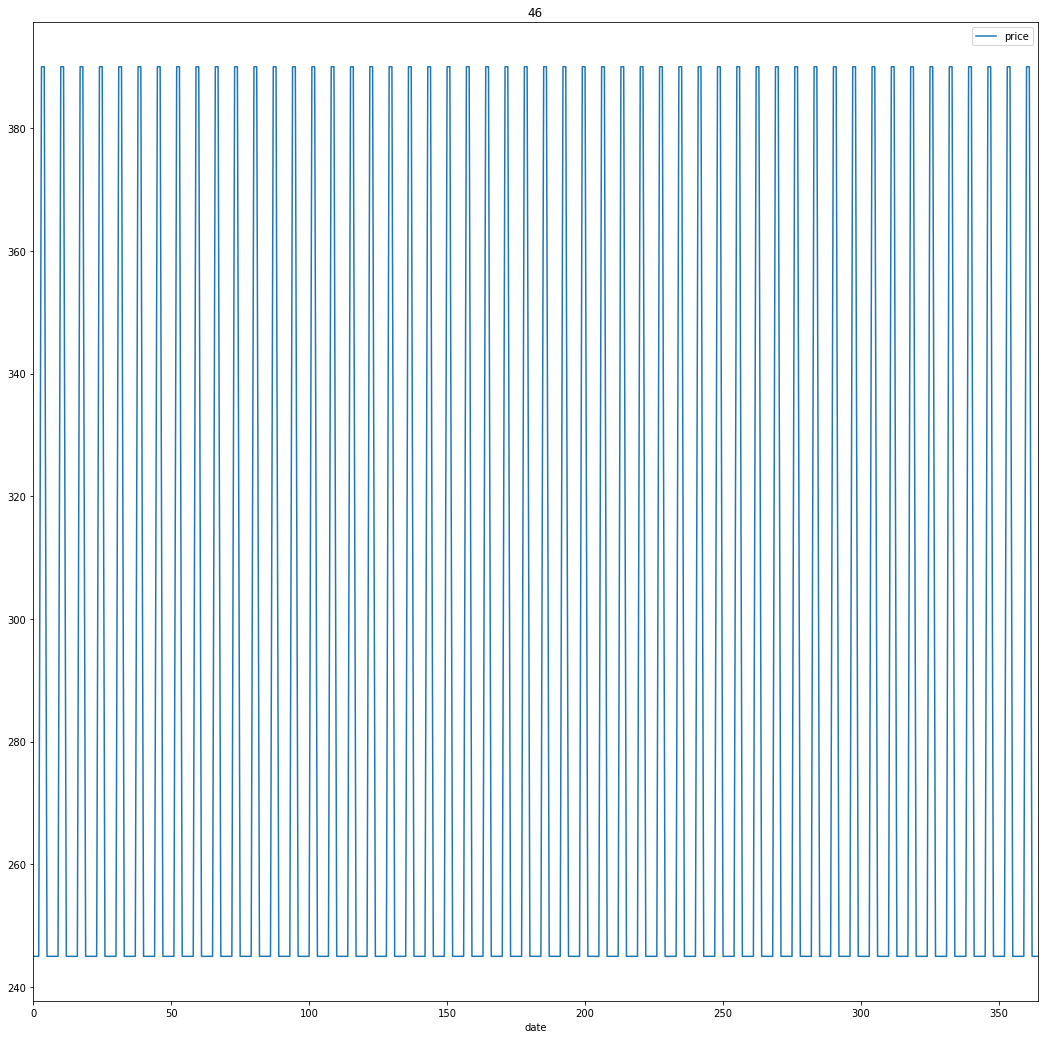

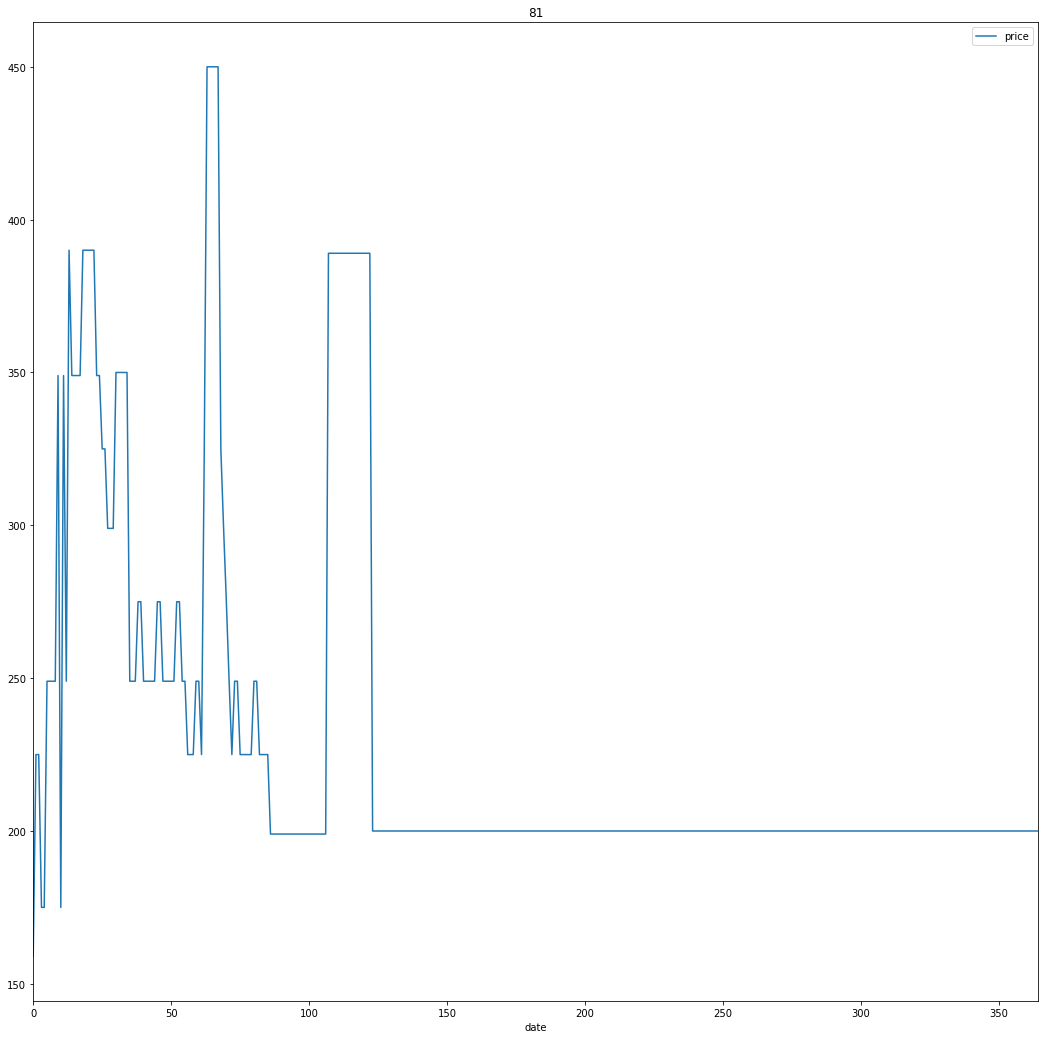

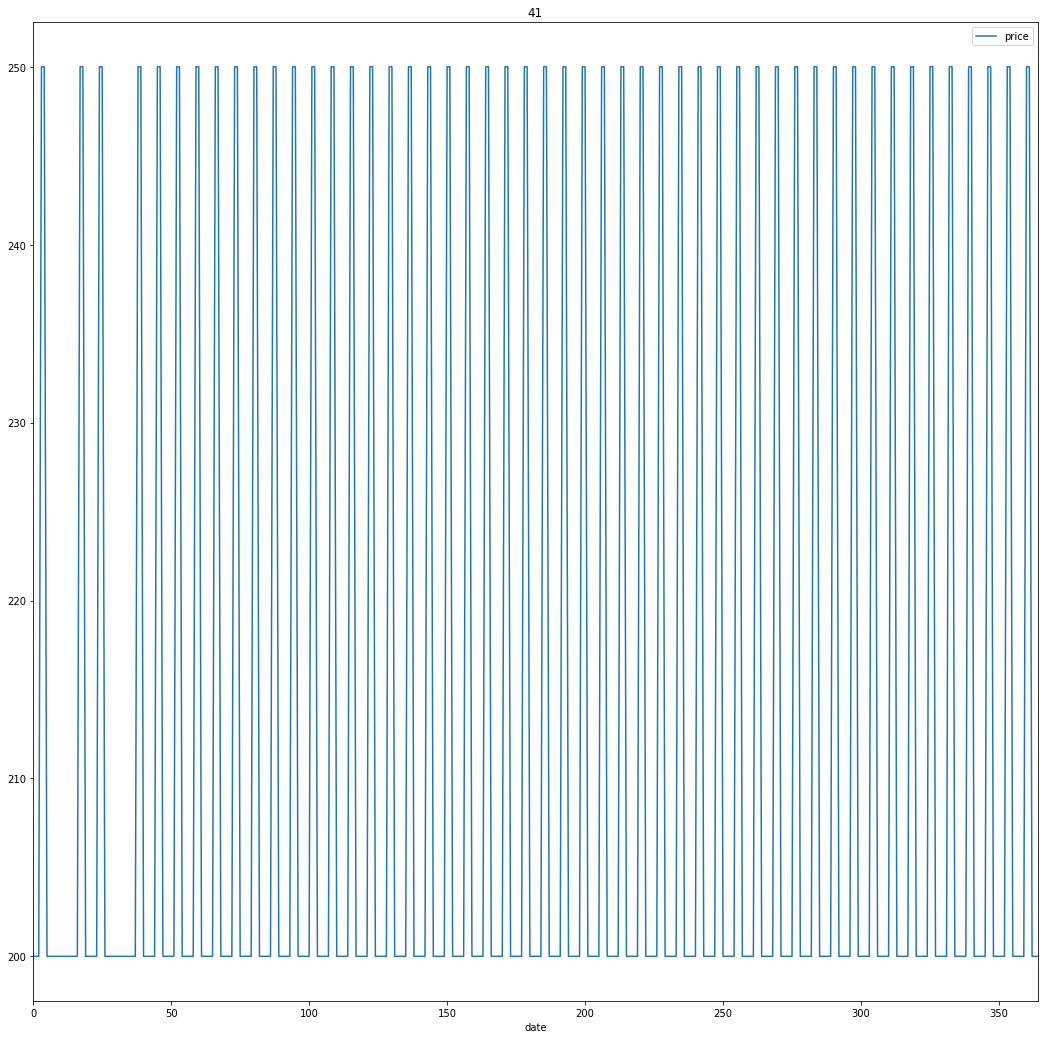

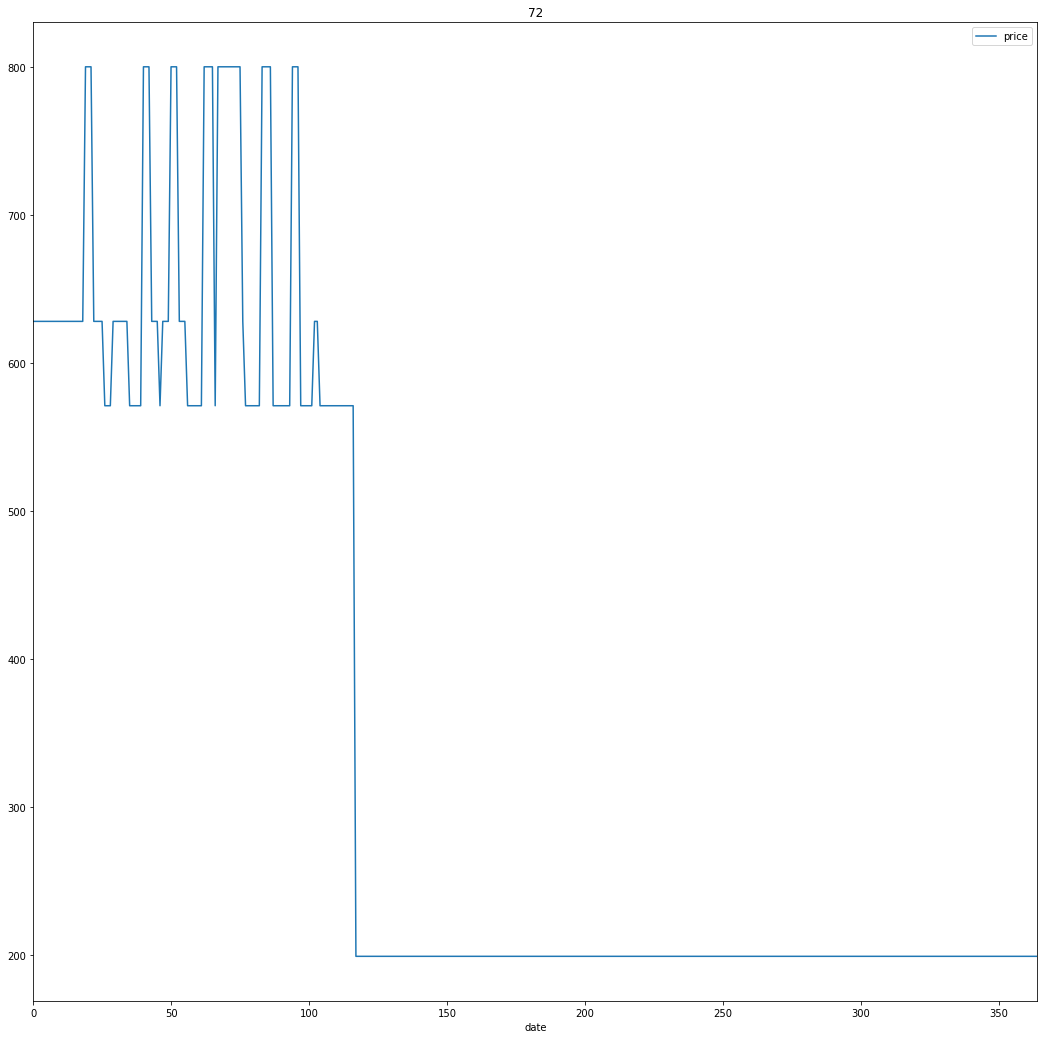

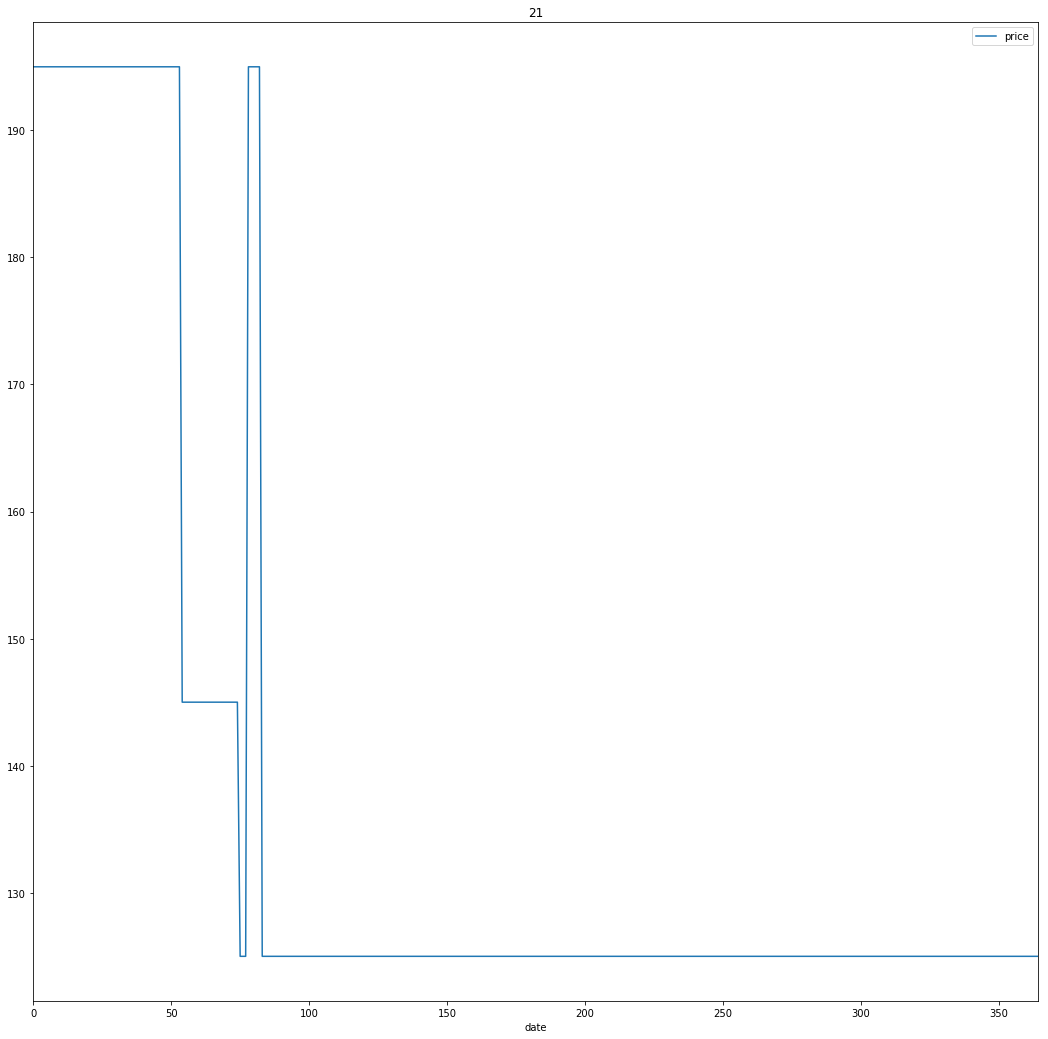

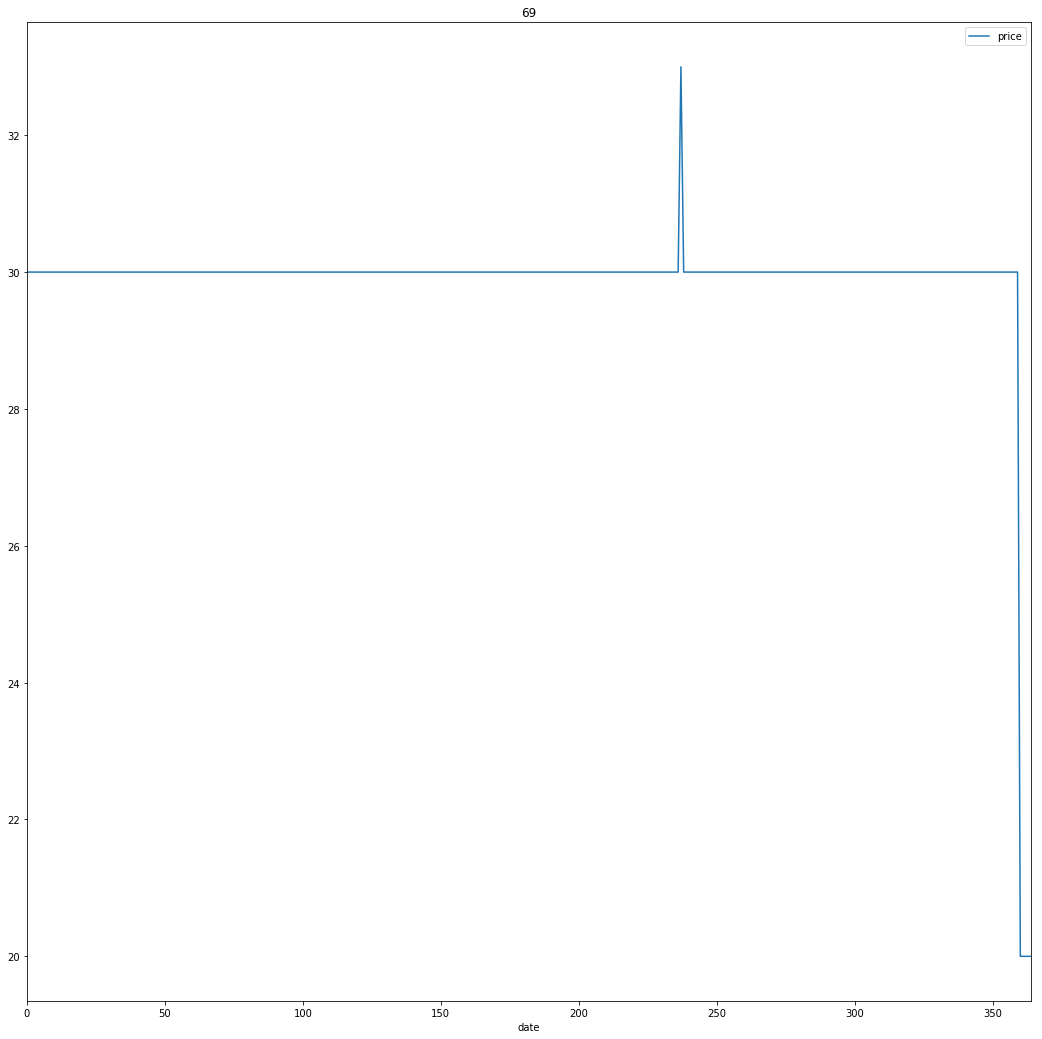

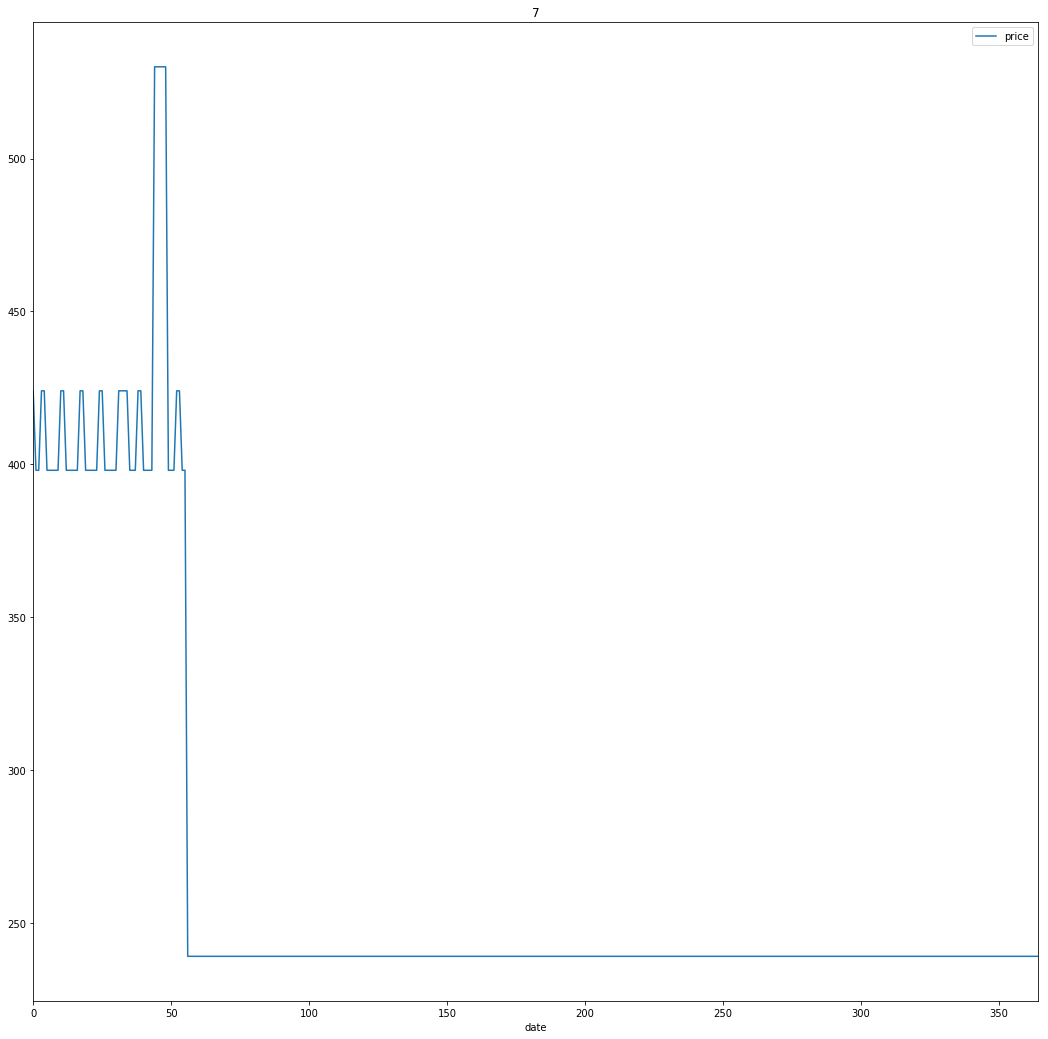

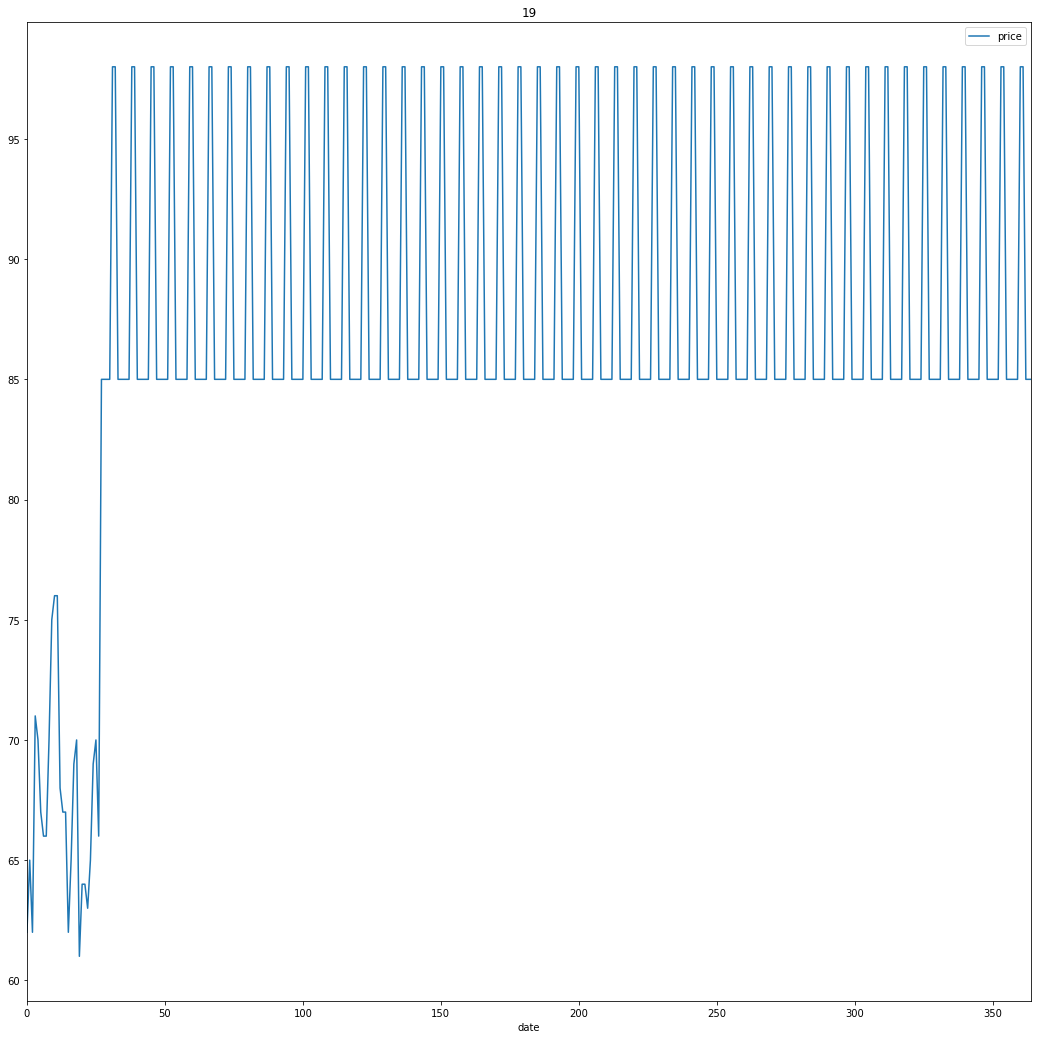

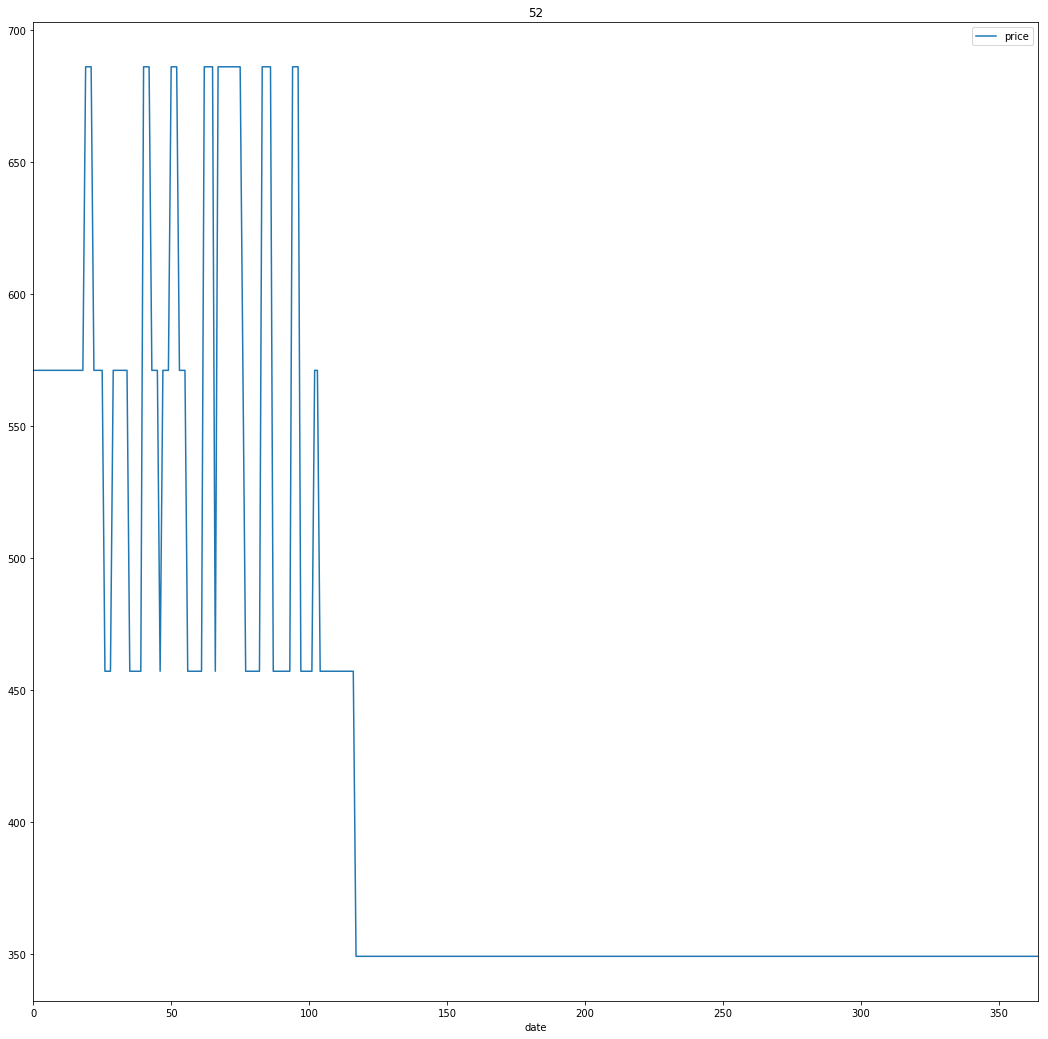

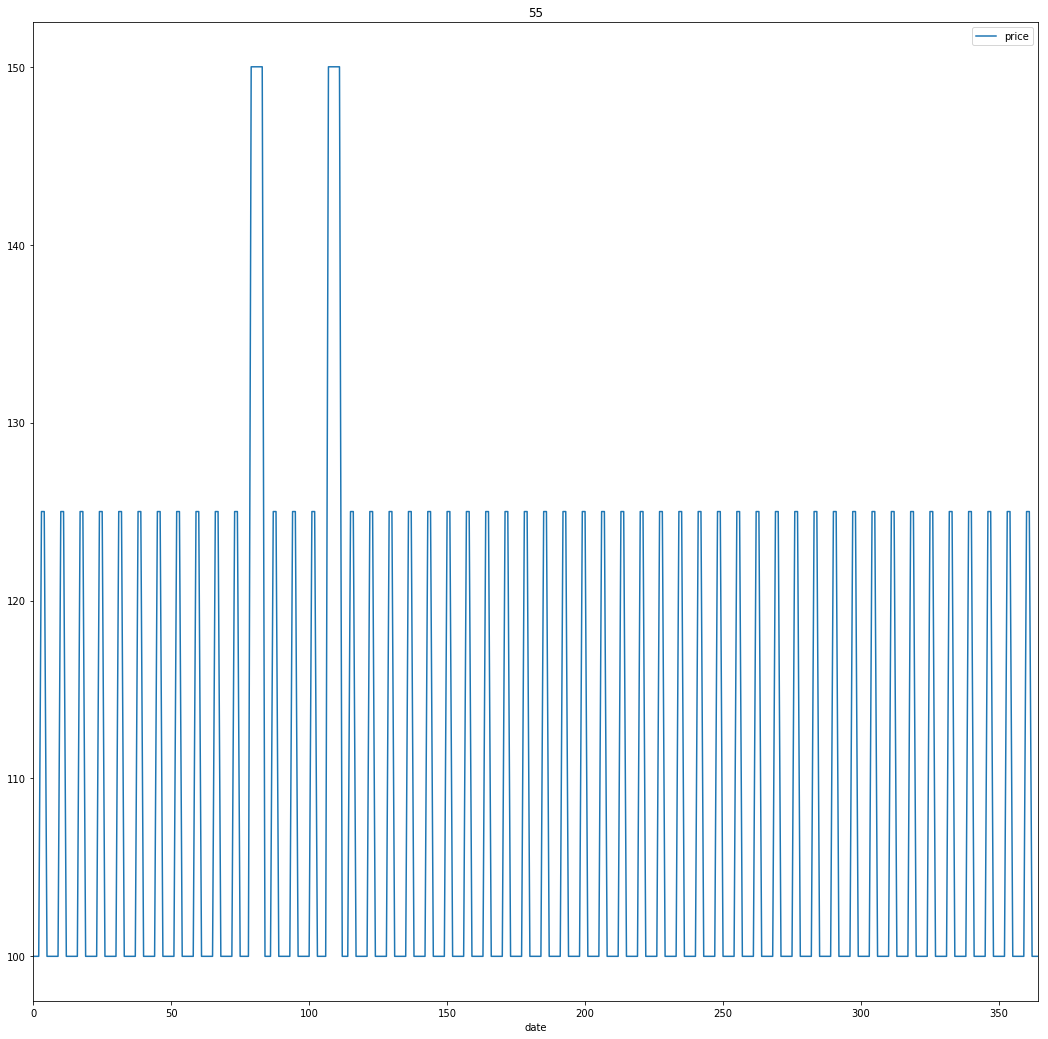

In [27]:
for id_ in np.random.permutation(price_not_same)[:20]:
    one_listing = boston_calendar[boston_calendar.listing_id == complete_id_list[id_]]
    dates_list = list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),one_listing.loc[:,'date']))
    min_date = min(dates_list)
    one_listing.loc[:,'date'] = list(map(lambda x: (x - min_date).days, dates_list))
    one_listing = one_listing.sort_values(by = 'date')
    one_listing.loc[:,'price'] = one_listing.loc[:,'price'].map(lambda x: float(''.join(e for e in x if e.isalnum()))/100) ## from $## to ## 
    one_listing.plot(x='date',y='price',figsize = (6*3,6*3),title=str(id_))

We find some trends of increase in price in the middle of year. let's see how to analyze this

Now we need to find a way to combine these graphs. 
First thing that comes to mind is to standardize all the arrays and add them and standardize the output and then plot the results.

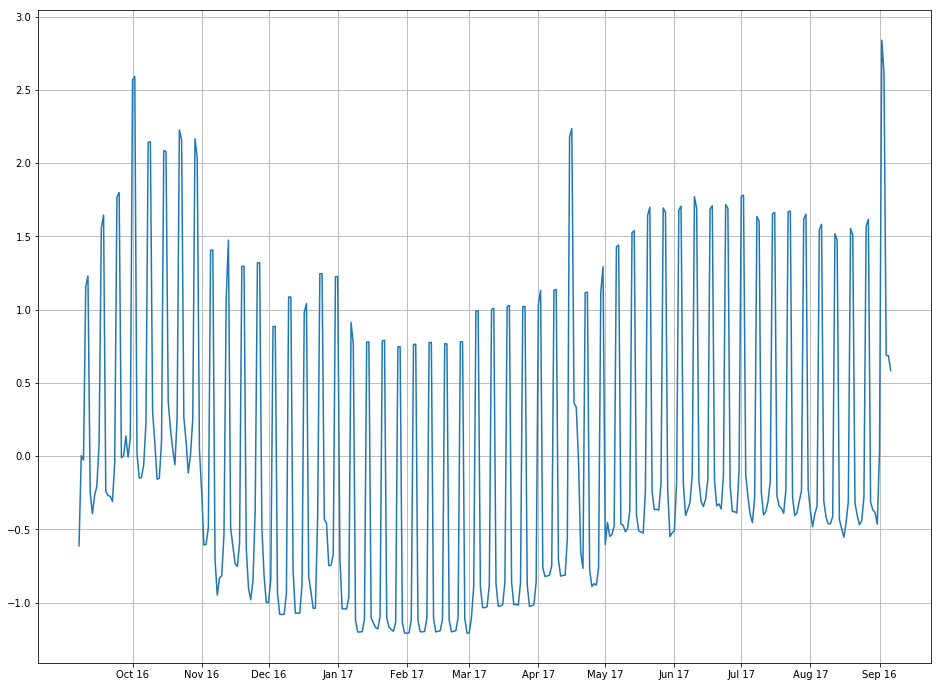

In [58]:
pd.options.mode.chained_assignment = None
combined_array = np.asarray([0]*365).reshape((-1,1))
for id_ in complete_id_list:
    one_listing = boston_calendar[boston_calendar.listing_id == id_]
    dates_list = list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),one_listing.loc[:,'date']))
    min_date = min(dates_list)
    one_listing.loc[:,'date'] = list(map(lambda x: (x - min_date).days, dates_list))
    one_listing = one_listing.sort_values(by = 'date')
    
    one_listing.loc[:,'price'] = one_listing.loc[:,'price'].map(lambda x: float(''.join(e for e in x if e.isalnum()))/100) ## from $## to ## 
    scl = StandardScaler()
    combined_array = combined_array + scl.fit_transform(one_listing.price.to_numpy().reshape((-1,1))) 
scl = StandardScaler()
combined_array =scl.fit_transform(combined_array).squeeze()
fig,ax = plt.subplots(figsize = (4*4,4*3))
ax.grid(True)
ax.set_xticks(first_day_each_month)
ax.set_xticklabels(labels = ['Jan 17','Feb 17','Mar 17','Apr 17','May 17','Jun 17','Jul 17','Aug 17','Sep 16','Oct 16','Nov 16','Dec 16'])
sns.lineplot(x=list(range(1,365+1)),y=combined_array,ax=ax);
pd.options.mode.chained_assignment = 'warn'

Perfect, we still have the weekend/weekdays fluctuations. 
What is more interesting is that there tends to be an increase throughout the year which is more evident in the summer months between June and September that prices decrease back to fluctuate around the mean

Now let's look at the other values, we will check values with at least values available for half the year roughly.

In [60]:
listing_ids = num_days[num_days.available > 356//2].index # Check values with at least values available for half the year roughly

In [61]:
listing_ids.shape

(1801,)

We transform the date and the price of the whole dataset to aid us with treating the NaN values later. 

In [62]:
dates_list = list(map(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'),boston_calendar.loc[:,'date']))
min_date = dt.datetime.strptime('2016-01-04','%Y-%m-%d')
boston_calendar.loc[:,'date'] = list(map(lambda x: (x - min_date).days, dates_list))
boston_calendar.loc[:,'price'] = boston_calendar.loc[:,'price'].map(\
                            lambda x:  np.nan if pd.isna(x) else float(''.join(e for e in x if e.isalnum()))/100) 

Since we already standardize inputs, we fill NaNs with means which will not affect our plots but will help us see the fluctuations of the available data

In [63]:
for id_ in listing_ids:
    current = boston_calendar[boston_calendar.listing_id == id_]
    boston_calendar.loc[boston_calendar.listing_id == id_,:] = \
    boston_calendar.loc[boston_calendar.listing_id == id_,:].fillna(current.mean(skipna=True))

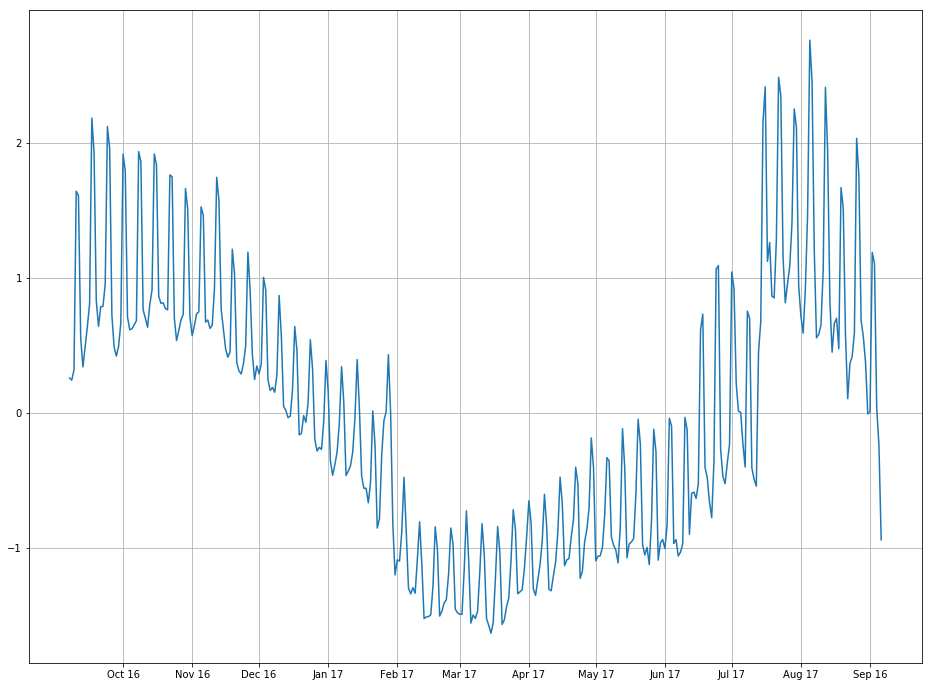

In [65]:
pd.options.mode.chained_assignment = None
combined_array = np.asarray([0]*365).reshape((-1,1))
for id_ in listing_ids:
    one_listing = boston_calendar[boston_calendar.listing_id == id_]
    scl = StandardScaler()
    combined_array = combined_array + scl.fit_transform(one_listing.price.to_numpy().reshape((-1,1))) 
scl = StandardScaler()
combined_array =scl.fit_transform(combined_array).squeeze()
fig,ax = plt.subplots(figsize = (4*4,4*3))
ax.grid(True)
ax.set_xticks(first_day_each_month)
ax.set_xticklabels(labels = ['Jan 17','Feb 17','Mar 17','Apr 17','May 17','Jun 17','Jul 17','Aug 17','Sep 16','Oct 16','Nov 16','Dec 16'])
sns.lineplot(x=list(range(1,365+1)),y=combined_array,ax=ax);
pd.options.mode.chained_assignment = 'warn'

Unsuprisingly, we find a similar trend similar to the plots above. That concludes our analysis of the calendar data 